# Industrial Gaussian Process Regression Introduction


### 본 자료는 ICMLA Tutorial로 진행된 Gaussian Process Regression 내용을 정리한 것입니다.

### https://github.com/likzet/Tutorial-on-Machine-Learning-for-Industrial-Predictive-Analytics

## Industrial analytics solutions의 핵심 방법 중 하나: Gaussain Process Regression

이 자료에서는 Gaussian Process Regression의 아래 기본적인 내용과 사용법을 다룹니다.
1. GP Modeling을 위한 라이브러리인 Gpy. [SheffieldML github page](https://github.com/SheffieldML/GPy).
2. GPR의 주요 가정.
3. GPR 모델 파라미터 추정 방법
4. GPR Classification과 GP 기반의 (좀 더) 복잡한 모델링
5. GPR을 위한 Covariance Function 선정


**GPy** 라이브러리의 장점?

* GP models (regression, classification, GPLVM)에 특화된 파이썬 라이브러리 (경험적으로 sklearn 보다 성능 우수)
* 다양한 covariance function 들이 구현되어 있음
* large-scale problems를 위한 GP 모델 사용 가능
* 사용하기 쉬움

Current documentation of GPy library can be found [here](http://gpy.readthedocs.org/en/latest/).

Some state of the art on Gaussian Process Regression:
1. Rasmussen C.E., Williams C.K. Gaussian processes for machine learning. Cambridge: MIT press. 2006.
2. Burnaev E.V., Panov M.E. and Zaytsev, A.A. Regression on the basis of nonstationary Gaussian processes with Bayesian regularization. Journal of communications technology and electronics, 61(6), pp.661-671. 2016.
3. Duvenaud, D.K., Nickisch H. and Rasmussen, C.E. Additive gaussian processes. NIPS. 226-234. 2011.
4. http://gpss.cc/

Gpy 라이브러리 사용을 위한 설치는 아래와 같이 pip를 통해 진행하면 됩니다.

In [1]:
!pip install GPy

In [2]:
%matplotlib notebook

from __future__ import print_function

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import GPy

from utility import plot_model, plot_model_2d #결과 visualization을 위해 구현해놓은 함수들

## Gaussian Process Regression

X에 대한 결과값 y로 구성된 데이터 셋 $\left (X, \mathbf{y} \right ) = \left \{ (\mathbf{x}_i, y_i), \mathbf{x}_i \in \mathbb{R}^d, y_i \in \mathbb{R} \right \}_{i = 1}^N$ 이 주어졌다고 가정할 때.  

* GPR의 주요 가정 (main assumption):
$$
y = f(\mathbf{x}) + \varepsilon,
$$
where $f(\mathbf{x})$ is a Gaussian Process and $\varepsilon \sim \mathcal{N}(0, \sigma_0^2)$ is a Gaussian noise .

이 때, 사후 확률 (Posterior distribution)은 아래와 같이 주어집니다. (* 표시는 unseen data, test data를 의미합니다)
$$
y_* | X, \mathbf{y}, \mathbf{x}_* \sim \mathcal{N}(m(\mathbf{x}_*), \sigma^2(\mathbf{x}_*)),
$$

위에서 표현된 predictive mean 과 variance 는 아래와 같이 계산할 수 있습니다.
$$
m(\mathbf{x}_*) = \mathbf{k}^T \mathbf{K}_y^{-1} \mathbf{y} = \sum_{i = 1}^N \alpha_i k(\mathbf{x}_*, \mathbf{x}_i),
$$
$$
\sigma^2(\mathbf{x}_*) = k(\mathbf{x}_*, \mathbf{x}_*) - \mathbf{k}^T\mathbf{K}_y^{-1}\mathbf{k},
$$
where
$$
\mathbf{k} = \left ( k(\mathbf{x}_*, \mathbf{x}_1), \ldots, k(\mathbf{x}_*, \mathbf{x}_n) \right )^T,
$$
$$
\mathbf{K} = \{ k(\mathbf{x}_i, \mathbf{x}_j) \}_{i, j = 1}^n
$$
$$
\mathbf{K}_y = \mathbf{K} + \sigma_0^2 \mathbf{I}.
$$

## GP regression is a way to impose priors over wide range of functions

GP는 함수 $f(\mathbf{x})$ 값들의 분포(distribution)을 정의하는 방법이며, 이 분포가 정규 분포 (Gaussian distribution)을 따른다고 가정합니다.

쉽게 말해보겠습니다. n 개의 $\mathbf{x}$와 $y$ 값이 있다고 합시다.
둘 사이의 관계는 $y=f(\mathbf{x})$ + $\epsilon$ 라고 가정합니다. ($\epsilon$은 노이즈 입니다.)

이 때, 우리는 주로 함수 f를 추정하기 위해 많은 노력을 합니다. 하지만, 이 작업은 쉽지 않습니다.

다른 접근 방법으로 생각할 수 있는 것은, 함수값 사이의 관계를 모델링하는 것인데요. 

우리가 관찰한 n개의 ($\mathbf{x}$에 따른) y 값들 사이의 관계가  Gaussian distribution을 따른다고 모델링함으로써 함수 f를 직접 추정하지 않고도,

데이터를 모델링하는 방법이라고 생각하면 직관적으로 받아들이기 쉽습니다.

우리가 모델링하는 함수값들의 Gaussian distribution의 mean function과 covariance를 $\mathbf{m}$, $\mathbf{K}$ 정의하면 아래와 같이 표현할 수 있습니다.

*mean function* $m(\mathbf{x})$ and *covariance function* $k(\mathbf{x}, \mathbf{x}')$ for any set $\mathbf{x}_1, \ldots, \mathbf{x}_n \in \mathbb{R}^d \rightarrow$ $\left (f(\mathbf{x}_1), \ldots, f(\mathbf{x}_n) \right ) \sim \mathcal{N}(\mathbf{m}, \mathbf{K})$,

where $\mathcal{m} = (m(\mathbf{x}_1, \ldots, \mathbf{x}_n))$, $\mathbf{K} = \{ k(\mathbf{x}_i, \mathbf{x}_j) \}_{i,j=1}^n$.

mean과 covariance function이 정의되어 있다면, 해당 Gaussian Process에서 샘플링 방법은 아래와 같아지겠죠?

Sampling procedure:

1. Generate set of points $\mathbf{x}_1, \ldots, \mathbf{x}_n$. (n 개의 훈련 데이터)
2. Calculate mean and covariance matrix $\mathcal{m} = (m(\mathbf{x}_1), \ldots, m(\mathbf{x}_n))$, $\mathbf{K} = \{ k(\mathbf{x}_i, \mathbf{x}_j) \}_{i,j=1}^n$. (n 개의 훈련 데이터로 GP의 mean과 covariance matrix 계산)
3. Generate vector from multivariate normal distribution $\mathcal{N}(\mathbf{m}, \mathbf{K})$. (2에서 추정한 GP를 따르는 확률 분포에서 데이터 샘플링)

<IPython.core.display.Javascript object>


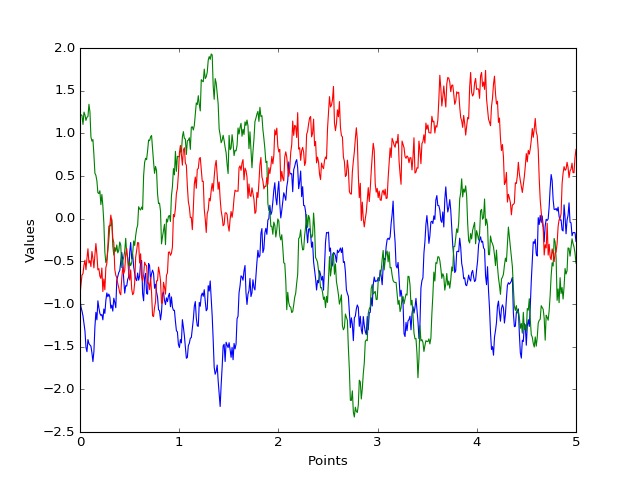

In [3]:
kernel = GPy.kern.Exponential(input_dim=1, lengthscale=0.9)

sample_size = 500
points = np.linspace(0, 5, sample_size).reshape(-1, 1)

mean_vector = np.zeros(sample_size)
covariance_matrix = kernel.K(points, points)

realization_number = 3
realizations = np.random.multivariate_normal(mean_vector, covariance_matrix, realization_number)

for index in range(realization_number):
    plt.plot(points, realizations[index, :]);
plt.xlabel('Points');
plt.ylabel('Values');

## Building GPR model

이제 GPR model을 사용해봅시다. 만약, 우리가 모델링하려는 함수 f가 아래와 같은 구조를 따른다고 가정해봅시다.
$$
f(x) = − \cos(\pi x) + \sin(4\pi x), \quad x \in [0, 1],
$$
with noise $y(x) = f(x) + \epsilon$, $\epsilon \sim \mathcal{N}(0, 0.1)$. 

위의 함수를 따르는 샘플 10개를 우선 만들어 봅시다.


<IPython.core.display.Javascript object>


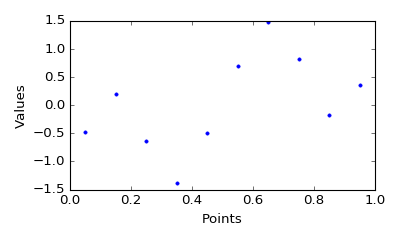

In [4]:
sample_size = 10 
points = np.linspace(0.05, 0.95, sample_size).reshape(-1, 1)
values = (-np.cos(np.pi * points) + np.sin(4 * np.pi * points) +
     np.random.normal(loc=0.0, scale=0.1, size=(sample_size, 1)))

plt.figure(figsize=(5, 3));
plt.plot(points, values, '.');
plt.xlabel('Points');
plt.ylabel('Values');
plt.tight_layout();

#### 1. Define covariance function

GP의 핵심은 결국 데이터 사이의 관계를 모델링하는데 사용하는 covariance function (kernel)을 무엇으로 정의할 것인가 입니다.

데이터 사이의 관계를 어떤 방식으로 설명하느냐에 따라, 우리가 학습하는 GP 모델의 결과가 달라지게됩니다.

대표적으로 사용하는 kernel은 RBF (or squared exponential) kernel 이며, 아래와 같은 식으로 표현됩니다.

RBF는 variance, length scale 두 가지 파라미터를 포함하고 있습니다.

$k(x, x') = \sigma^2 \exp\left ( -\dfrac{\|x - x'\|^2}{2l^2}\right )$,
where 
* `variance` is $\sigma^2$ : Basic Variance of function f
* `lengthscale` is $l$. : control parameter for distance between data points


아래와 같이 GPy.kern.RBF 함수를 사용하여 kernel을 정의할 수 있습니다.

(length scale 변화에 따라 kernel 값이 어떻게 변하는지는 아래에서 눈으로 확인해보겠습니다.)

사용하고자 하는 다양한 kernel 또한 GPy 라이브러리 안에 들어있으니, 도큐먼트를 확인해보세요 :)

In [5]:
input_dim = 1
variance = 1
lengthscale = 0.2
kernel = GPy.kern.RBF(input_dim, variance=variance,
                      lengthscale=lengthscale)

#### 2. Create GPR model


Name : GP regression
Objective : 13.3761056608
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    0.2  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


<IPython.core.display.Javascript object>


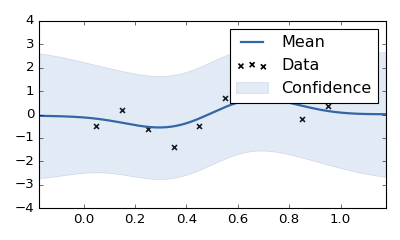

In [6]:
model = GPy.models.GPRegression(points, values, kernel)
print(model)
model.plot(figsize=(5, 3));

### Parameters of the covariance function

covariance function의 파라미터는 다음과 같이 설정됩니다.  `kernel.lengthscale = 0.1`.

여기서는 length scale 크기에 따라 RBF가 나타내는 함수를 눈으로 확인해볼까요?

수식에서 바로 알 수 있듯이, length scale이 커지면 커질수록 RBF kernel은 평평한 함수가 됩니다.

즉, 데이터 사이의 거리가 충분히 멀더라도 covariance가 높다고 판단하죠. 

반대로 length_scale이 아주 작다면, 매우 가까이 있는 데이터는 covariance가 높다고 판단하지만, 거리가 멀어질 경우 covariance가 매우 낮다고 판단하게 됩니다.

Let's change the value of `lengthscale` parameter and see how it changes the covariance function.

<IPython.core.display.Javascript object>


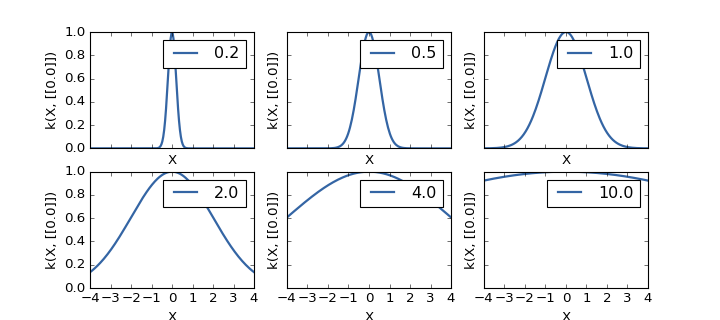

In [7]:
kernel = GPy.kern.RBF(1)
lengthscale_array = np.array([0.2, 0.5, 1, 2, 4, 10])
figure_handle, axes = plt.subplots(2, 3, figsize=(9, 4), 
                                   sharex=True, sharey=True)
for lengthscale, selected_axes in zip(lengthscale_array, axes.ravel()):
    kernel.lengthscale = lengthscale
    kernel.plot(ax=selected_axes)
    selected_axes.set_ylim([0, 1])
    selected_axes.set_xlim([-4, 4])
    selected_axes.legend([lengthscale])

<IPython.core.display.Javascript object>


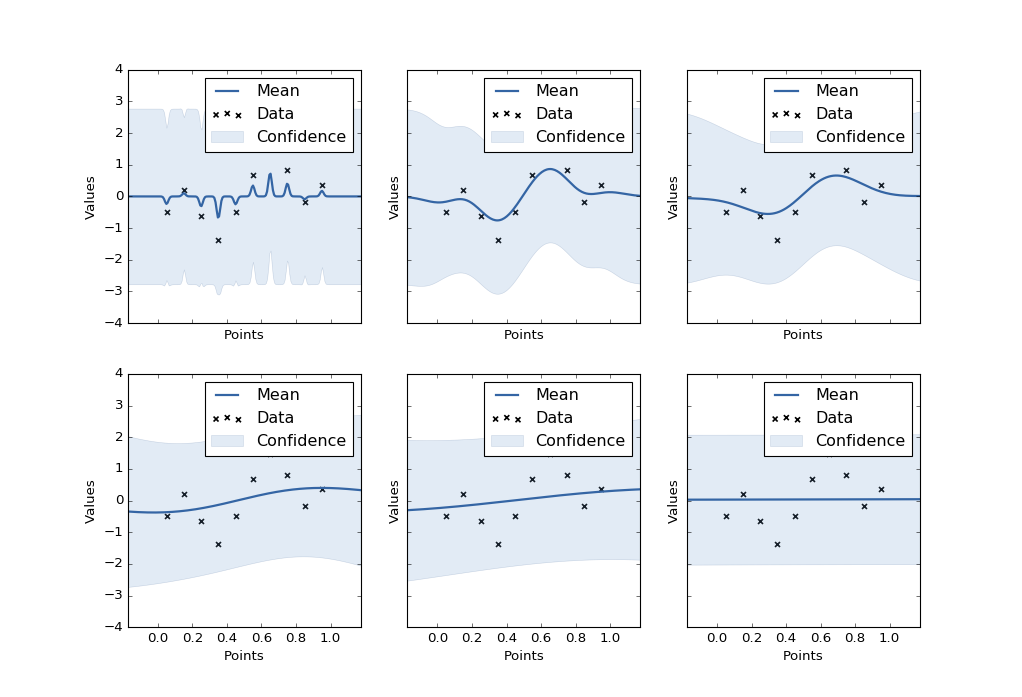

In [8]:
# Let us try to change parameters to obtain more accurate model.
kernel = GPy.kern.RBF(1)
lengthscale_array = np.asarray([0.01, 0.1, 0.2, 0.5, 1, 10])
figure_handle, axes = plt.subplots(2, 3, figsize=(9.5, 5), sharex=True, sharey=True)

for lengthscale, selected_axes in zip(lengthscale_array, axes.ravel()):
    kernel.lengthscale = lengthscale
    model = GPy.models.GPRegression(points, values, kernel)
    # print(model)
    model.plot(ax=selected_axes)
    selected_axes.set_xlabel('Points')
    selected_axes.set_ylabel('Values')

## Tuning parameters of covariance function

그렇다면, covariance function의 파라미터는 어떻게 튜닝해야할까요? 튜닝은 일반적으로
1. likelihood를 최대화 maximizing likelihood. 
2. LOO CV (Leave-one-out Cross-Validation) score.

두 가지를 확인합니다. 이론적으로 알고 계신 분들은, 어떻게 조절해야하실지 아실 듯 하여 생략하겠습니다.

GPy는 하나하나 튜닝이 귀찮으신 여러분을 위해
모델에 model.optimizer() 함수를 제공합니다. 아래 예제에서 확인하십시오 ^^


## Likelihood optimization

Likelihood for Gaussian process regression has the form:
$$
L(k(\mathbf{x}, \mathbf{x}')) = \frac12 [n \sqrt{2 \pi} + \ln |\mathbf{K}_y| + \mathbf{y}^T \mathbf{K}^{-1}_y \mathbf{y}].
$$

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0007   9.197937e+00   6.617573e+00 
    00s03  0013   8.576994e+00   5.119890e-02 
    00s04  0015   8.541623e+00   3.103352e-01 
    00s07  0025   8.523235e+00   9.679574e-04 
    00s07  0027   8.523183e+00   1.674028e-04 
    00s11  0038   8.523161e+00   5.837588e-07 
    00s12  0041   8.523160e+00   1.984648e-08 
Runtime:     00s12
Optimization status: Converged

Print Model

Name : GP regression
Objective : 8.52316049345
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |  priors
  rbf.variance             |     0.914432480113  |      +ve      |        
  rbf.lengthscale          |     0.121471818082  |      +ve      |        
  Gaussian_noise.variance  |  2.45528201711e-10  |      +ve      |        


<IPython.core.display.Javascript object>


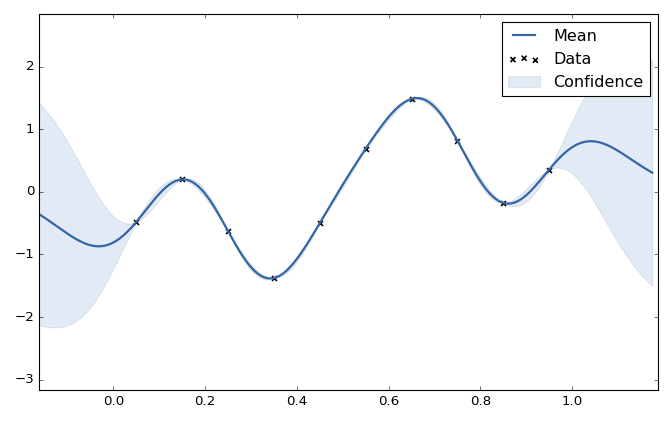

In [11]:
kernel = GPy.kern.RBF(1, lengthscale=0.1)
model = GPy.models.GPRegression(points, values, kernel)

model.optimize(messages=True)

print("Print Model")
print(model)
model.plot(figsize=(5, 3));

### Noise variance

우리가 GP 모델에 추가하는 Noise의 variance $\sigma_0$ 는 cost function에서 regularization과 같은 역할을 합니다.

즉, noise가 커지면 우리가 보유하고 있는 데이터에 대한 불확실도가 올라가므로 좀 더 일반화된 방향으로 모델이 학습되겠죠?

Noise variance 값이 커지면, 우리의 훈련 데이터에 특화되는 성향이 낮아지므로, 좀 더 스무스(smooth) 한 모델이 학습됩니다.

$$
\mathbf{K}_y = \mathbf{K} + \sigma_0^2 \mathbf{I}.
$$

아래와 같이 설정할 수 있습니다.

`model.Gaussian_noise.variance = 1`

<IPython.core.display.Javascript object>


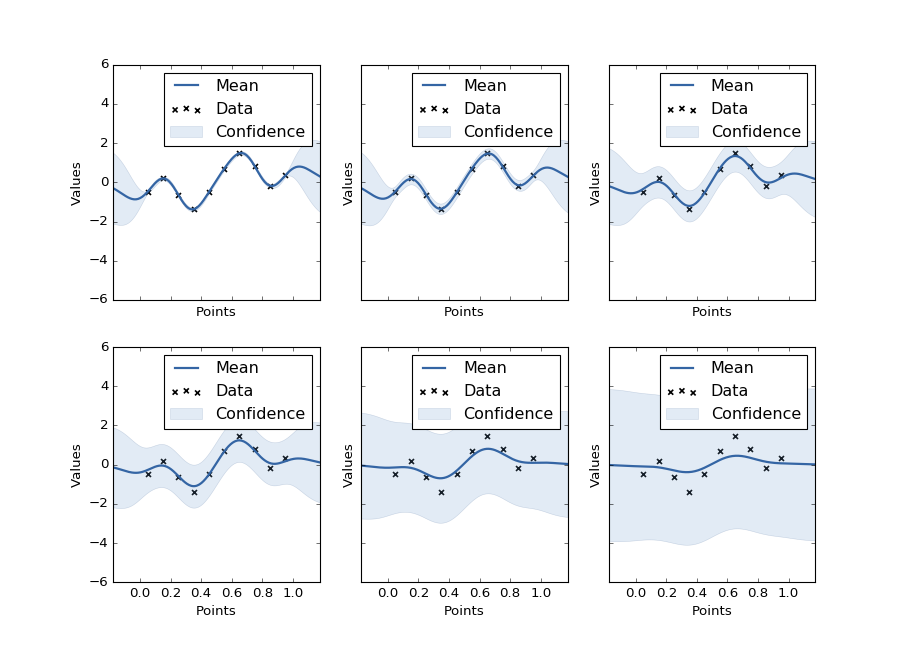

In [12]:
noise_variance_array = [1e-3, 1e-2, 0.1, 0.2, 1, 3]
figure_handle, axes = plt.subplots(2, 3, figsize=(9.5, 5), sharex=True, sharey=True)

for noise_variance, selected_axes in zip(noise_variance_array, axes.ravel()):
    model.Gaussian_noise.variance = noise_variance
  
    model.plot(ax=selected_axes)
    selected_axes.set_xlabel('Points')
    selected_axes.set_ylabel('Values')

# Gaussian Process Classification

### Classification

우리가 맞추어야할 정답인 y가 categorical data인 경우, 우리는 classification이라고 하는데요.
GP를 통해서 Classification을 수행하는 것도 동일합니다.

Classification을 위한 데이터가 $\left (X, \mathbf{y} \right ) = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \{+1, -1\} \right \}_{i = 1}^n$ 로 주어졌다고 해봅시다.

머신러닝 세계에서는 x가 주어졌을 때 x의 category를 단도직입적으로 맞추는 것이 아닌, 확률적으로 맞추는 것을 일반적인 접근으로 여기고 있습니다. 즉,

Assumption:
$$
p(y = +1 \; | \; x) = \sigma(f(x)) = \pi(x),
$$
where latent function $f(x)$ is a realization of Gaussian Process.

새로운 데이터에 대한 확률적인 예측은 아래와 같이 표현됩니다.:
$$
\pi_* = p(y_* \; | \; X, \mathbf{y}, x_*) = \int \sigma(f_*) p(f_* \; | \; X, \mathbf{y}, x_*) df_*,
$$
$$
p(f_* \; | \; X, \mathbf{y}, x_*) = \int p(f_* \; | \; X, x_*, \mathbf{f}) p(\mathbf{f} \; | \; X, \mathbf{y}) d\mathbf{f},
$$
where $p(\mathbf{f} \; |\; X, \mathbf{y}) = \dfrac{p(\mathbf{y} | X, \mathbf{f}) p(\mathbf{f} | X)}{p(\mathbf{y} | X)}$ is the posterior over the latent variables.

*Both integrals are intractable.*

We need to use approximation technique like Laplace approximation or Expectation Propagation.

### 아래부터는 cylinder 모양의 classification 데이터를 만들어서, 직접 GP를 통해 Classification 해보겠습니다.

<IPython.core.display.Javascript object>


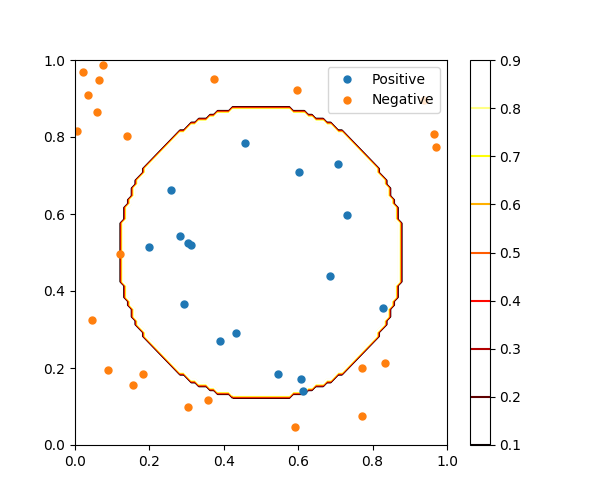

In [11]:
def cylinder(point):
    # toy function
    value = (1 / 7.0 - (point[:, 0] - 0.5)**2 - (point[:, 1] - 0.5)**2) > 0
    return value

np.random.seed(42)
points = np.random.rand(40, 2)
values = cylinder(points)

x_grid = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
y_grid = cylinder(np.hstack((x_grid[0].reshape(-1, 1), x_grid[1].reshape(-1, 1)))).reshape(x_grid[0].shape)

positive_idx = values == 1
plt.figure(figsize=(6, 5))
plt.plot(points[positive_idx, 0], points[positive_idx, 1], '.', markersize=10, label='Positive')
plt.plot(points[~positive_idx, 0], points[~positive_idx, 1], '.', markersize=10, label='Negative')
im = plt.contour(x_grid[0], x_grid[1], y_grid, 10, cmap=cm.hot)

plt.colorbar(im)
plt.legend()
plt.show()

GP Classification은 kernel 함수를 설정한 후, GPy.models.GPClassification 함수를 통해 쉽게 구현하실 수 있습니다.
argument로 데이터 포인트와 각 데이터 포인트의 label, kernel을 각각 받으며, 바로 모델을 생성하실 수 있습니다.


Name : gp_classification
Objective : 18.804605171659013
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp_classification.  |          value  |  constraints  |  priors
  rbf.variance        |  5.46880383079  |      +ve      |        
  rbf.lengthscale     |           (2,)  |      +ve      |        


<IPython.core.display.Javascript object>


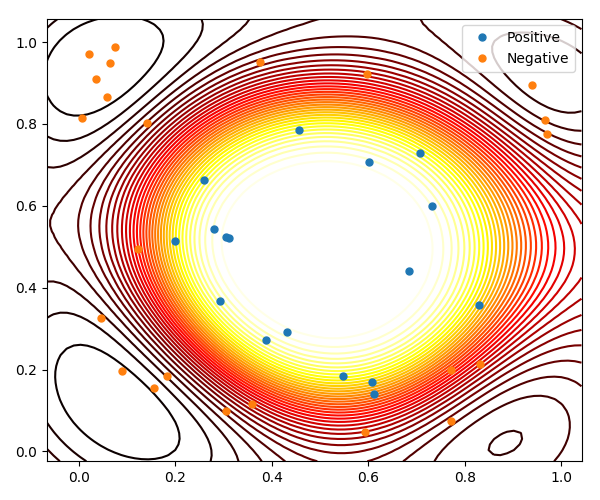

 /home/yermek/.local/lib/python3.5/site-packages/matplotlib/contour.py:967: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


In [12]:
kernel = GPy.kern.RBF(2, variance=1., lengthscale=0.2, ARD=True)

model = GPy.models.GPClassification(points, values.reshape(-1, 1), kernel=kernel)
model.optimize()
print(model)

plot_model_2d(model, points, values)

Let's change lengthscale to some small value

<IPython.core.display.Javascript object>


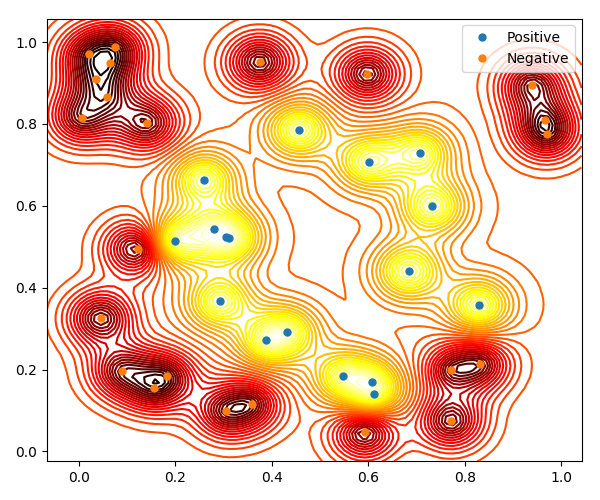

 /home/yermek/.local/lib/python3.5/site-packages/matplotlib/contour.py:967: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


In [13]:
model.rbf.lengthscale = [0.05, 0.05]
plot_model_2d(model, points, values)

# Covariance functions

GP 모델링에서 주로 사용하는 covariance function 들에 대하여 알아보겠습니다.

`print(kernel)`을 사용하면 covariacne function에 대한 간략한 정보를 확인하실 수 있습니다.

In [14]:
kernel = GPy.kern.RBF(1)
print(kernel)

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        


kernel.plot을 사용하시면 covariance function을 시각화하실 수 있습니다.

<IPython.core.display.Javascript object>


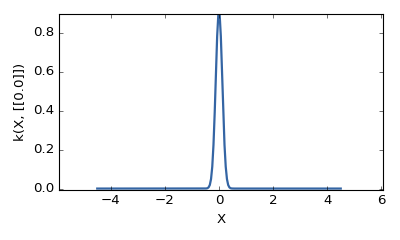

In [13]:
kernel.plot(figsize=(5, 3))

### Heaviside function

RBF가 가장 많이 사용되는 covariance function 이지만, 이 외에도 다양한 함수들이 존재합니다.
상황에 따라 적합한 covariance function을 사용하는 것이 중요한데요.

예를 들어서,gradient가 매우 큰 부분을 포함하거나 불연속적인 점에서 RBF를 사용할 경우 모델링이 제대로 되지 않을 수 있습니다.

<IPython.core.display.Javascript object>


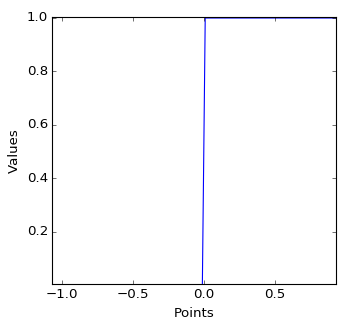

In [21]:
def heaviside(points):
    return np.asfarray(points > 0)

points = np.linspace(-1, 1, 100)
values = heaviside(points)
plt.figure(figsize=(5, 5))
plt.plot(points, values)
plt.xlabel('Points')
plt.ylabel('Values')
plt.tight_layout()


Name : GP regression
Objective : -16.6736390208
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |             value  |  constraints  |  priors
  rbf.variance             |    0.329609141254  |      +ve      |        
  rbf.lengthscale          |    0.158111386795  |      +ve      |        
  Gaussian_noise.variance  |  0.00177733412942  |      +ve      |        


<IPython.core.display.Javascript object>


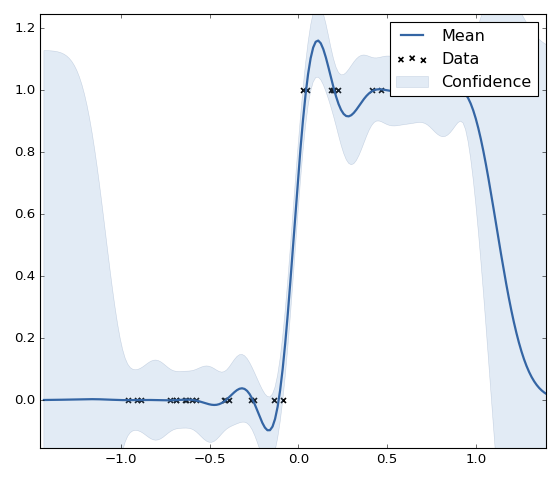

In [22]:
np.random.seed(42)
points = np.random.rand(30, 1) * 2 - 1
values = heaviside(points)

kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

model = GPy.models.GPRegression(points, values, kernel)
model.optimize()
print(model)

model.plot(figsize=(7, 6))
plt.ylim([-0.2, 1.2])
plt.tight_layout()

실제로는 매우 간단한 함수인데, RBF를 사용할 경우 제대로 피팅되지 않은 부분이 많은 것을 보셨나요?

이렇게 Heavised function이나 불연속적인 함수를 표현할 때 RBF는 적합하지 않을 수 있습니다. 

아래 다양한 covariance function을 사용해보세요. 

### Covariance functions in GPy

Popular covariance functions: `Exponential`, `Matern32`, `Matern52`, `RatQuad`, `Linear`, `StdPeriodic`. 

* Exponential:
$$
k(x, x') = \sigma^2 \exp \left (-\frac{r}{l} \right), \quad r = \|x - x'\|
$$

* Matern32
$$
k(x, x') = \sigma^2 \left (1 + \sqrt{3}\frac{r}{l} \right )\exp \left (-\sqrt{3}\frac{r}{l} \right )
$$

* Matern52
$$
k(x, x') = \sigma^2 \left (1 + \sqrt{5}\frac{r}{l} + \frac{5}{3}\frac{r^2}{l^2} \right ) \exp \left (-\sqrt{5}\frac{r}{l} \right )
$$

* RatQuad
$$
k(x, x') = \left ( 1 + \frac{r^2}{2\alpha l^2}\right )^{-\alpha}
$$

* Linear
$$
k(x, x') = \sum_i \sigma_i^2 x_i x_i'
$$

* Poly
$$
k(x, x') = \sigma^2 (x^T x' + c)^d
$$

* StdPeriodic
$$
k(x, x') = \sigma^2 \exp\left ( -2 \frac{\sin^2(\pi r)}{l^2}\right )
$$

<IPython.core.display.Javascript object>


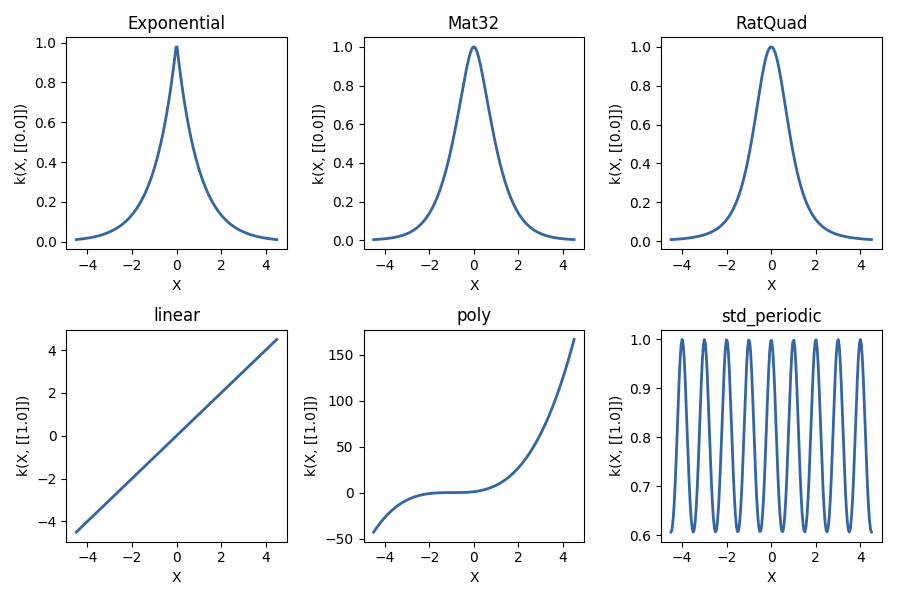

In [18]:
covariance_functions = [GPy.kern.Exponential(1), GPy.kern.Matern32(1),
                        GPy.kern.RatQuad(1), GPy.kern.Linear(1),
                        GPy.kern.Poly(1), GPy.kern.StdPeriodic(1)]
figure, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.ravel()
for index, kernel in enumerate(covariance_functions):
    kernel.plot(ax=axes[index])
    axes[index].set_title(kernel.name)
figure.tight_layout()

## Combinations of covariance functions

* Sum of covariance functions is a valid covariance function:

$$
k(x, x') = k_1(x, x') + k_2(x, x')
$$

* Product of covariance functions is a valid covariance funciton:
$$
k(x, x') = k_1(x, x') k_2(x, x')
$$

### Combinations of covariance functions in GPy

GPy에서는 kernel들의 합이나 곱을 편하게 계산할 수 있도록 operator overloading이 구현되어 있습니다.

(In GPy to combine covariance functions you can just use operators `+` and `*`.)

예를 들어, 두 kernel의 합으로 새로운 kernel을 정의하고 싶으시다면, 아래와 같이 구현하시면 됩니다.

  sum.              |  value  |  constraints  |  priors
  linear.variances  |    1.0  |      +ve      |        
  rbf.variance      |    2.0  |      +ve      |        
  rbf.lengthscale   |    1.0  |      +ve      |        


<IPython.core.display.Javascript object>


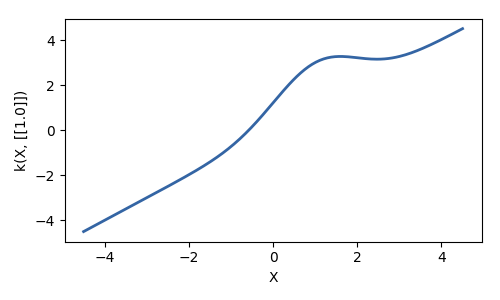

In [19]:
first_kernel = GPy.kern.Linear(1)
second_kernel = GPy.kern.RBF(1, variance=2., lengthscale=1)
kernel = first_kernel + second_kernel
print(kernel)
kernel.plot(figsize=(5, 3));

#### Linear times Periodic

  mul.                      |  value  |  constraints  |  priors
  linear.variances          |    1.0  |      +ve      |        
  std_periodic.variance     |    1.0  |      +ve      |        
  std_periodic.period       |    1.0  |      +ve      |        
  std_periodic.lengthscale  |    1.0  |      +ve      |        


<IPython.core.display.Javascript object>


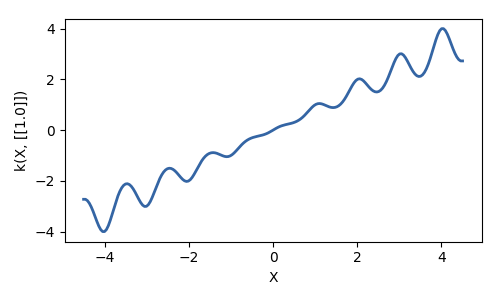

In [20]:
kernel = GPy.kern.Linear(1) * GPy.kern.StdPeriodic(1)
print(kernel)
kernel.plot(figsize=(5, 3));

## Additive kernels

One of the popular approach to model the function of interest is
$$
f(x) = \sum_{i=1}^d f_i(x_i) + \sum_{i < j} f_{ij}(x_i, x_j) + \ldots
$$

**Example**: $\quad f(x_1, x_2) = f_1(x_1) + f_2(x_2)$  
To model it using GP use additive kernel $\quad k(x, x') = k_1(x_1, x'_1) + k_2(x_2, x'_2)$.

More general - add kernels each depending on subset of inputs
$$
k(x, x') = k_1(x, x') + \ldots + k_D(x, x'),
$$
where, for example, $k_1(x, x') = k_1(x_1, x_1'), \; k_2(x, x') = k_2((x_1, x_3), (x_1', x_3'))$, etc.



<IPython.core.display.Javascript object>


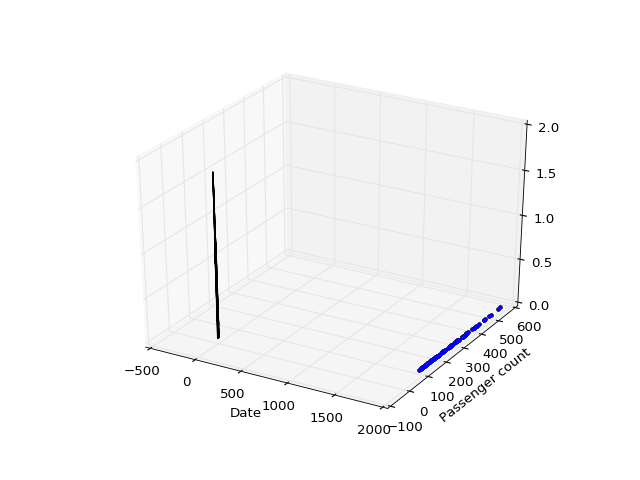

In [23]:
first_kernel = GPy.kern.RBF(1, active_dims=[0])
second_kernel = GPy.kern.RBF(1, active_dims=[1])

kernel = first_kernel + second_kernel

x = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
x = np.hstack((x[0].reshape(-1, 1), x[1].reshape(-1, 1)))
z = kernel.K(x, np.array([[0, 0]]))

figure = plt.figure()
ax = figure.add_subplot(111, projection='3d')
ax.plot_surface(x[:, 0].reshape(50, 50), x[:, 1].reshape(50, 50), z.reshape(50, 50), cmap=cm.viridis)
plt.show()

### Kernels on arbitrary types of objects

Kernels 은 다양한 타입의 obejct 사이에서도 역시 정의될 수 있습니다. 

즉, 그 대상이 수치화된 데이터 뿐 아니라, 텍스트, 이미지, 행렬, 그래프 등 다양합니다.

결국 우리가 초점을 맞출 것은 object 사이의 유사도(similarity)를 안다는 것이기 때문이에요.

#### Kernels on categorical data

* Represent your categorical variable as a by a one-of-k encoding: $\quad x = (x_1, \ldots, x_k)$.
* Use RBF kernel with `ARD=True`: $\quad k(x , x') = \sigma^2 \prod_{i = 1}^k\exp{\left ( -\dfrac{(x_i - x_i')^2}{\sigma_i^2} \right )}$. The lengthscale will now encode whether the rest of the function changes.
* Short lengthscales for categorical variables means your model is not sharing any information between data of different categories. 

# Real data on international flights

이번에는 GP 모델을 사용하여 실제 데이터를 예측해보도록 하겠습니다.

International flights에서 측정한 airline passenger 데이터에 GP를 적용해볼 텐데요.

input variable은 traffic for selected date 하나이지만, 데이터가 상당히 noisy하고 주기적인 성향을 가지고 있습니다.

아래 그림과 같이요. GP를 통하여 모델링할 수 있을까요?

<IPython.core.display.Javascript object>


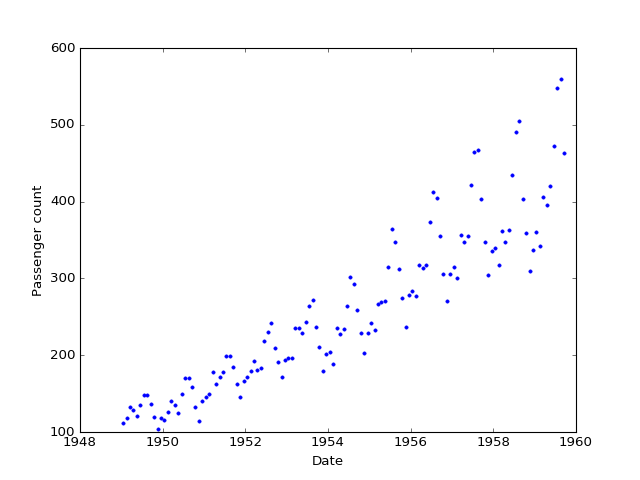

In [32]:
data = np.loadtxt('airline.csv', skiprows=1)
points = data[:, [0]]
values = data[:, [1]]
figure = plt.figure()
plt.plot(points, values, '.')
plt.xlabel('Date')
plt.ylabel('Passenger count')
plt.show()

#### Let's try RBF kernel

위의 데이터를 RBF kernel을 사용하여 모델링해보겠습니다.
결과가 잘 나올까요?


Name : GP regression
Objective : 670.442016131
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  rbf.variance             |  255631.021183  |      +ve      |        
  rbf.lengthscale          |   16.622531261  |      +ve      |        
  Gaussian_noise.variance  |  1654.47439066  |      +ve      |        


<IPython.core.display.Javascript object>


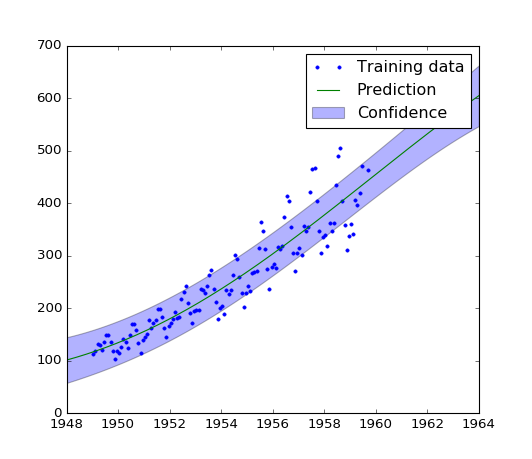

In [33]:
kernel_rbf = GPy.kern.RBF(1)
plot_model(points, values, kernel_rbf)

단순한 RBF kernel을 가지고는 데이터가 가지고 있는 주기적인 특성을 잘 모델링하지 못하는 것을 확인했습니다.

여기서 우리가 알 수 있는 것은, 우리가 모델링할 데이터의 특성이 크게 3 부분으로 나눠질 수 있다는 것입니다. 1) trend, 2) seasonality, 3) noise

따라서, 우리의 kernel 역시 3 가지 kernel의 합으로 표현해보도록 하겠습니다.

`kernel = kernel_trend + kernel_seasonality + kernel_noise`


Name : GP regression
Objective : 503.140337896
Number of Parameters : 14
Number of Optimization Parameters : 14
Updates : True
Parameters:
  GP_regression.                    |              value  |  constraints  |  priors
  sum.poly.variance                 |  1.67269096444e-06  |      +ve      |        
  sum.poly.scale                    |  1.67269956512e-06  |      +ve      |        
  sum.poly.bias                     |      0.99999730585  |      +ve      |        
  sum.rbf.variance                  |      100.139957873  |      +ve      |        
  sum.rbf.lengthscale               |     0.553631238701  |      +ve      |        
  sum.mul.std_periodic.variance     |      0.25266671523  |      +ve      |        
  sum.mul.std_periodic.period       |      1.00267485125  |      +ve      |        
  sum.mul.std_periodic.lengthscale  |     0.532100188636  |      +ve      |        
  sum.mul.linear.variances          |     0.252666714983  |      +ve      |        
  sum.mul.rbf.varian

<IPython.core.display.Javascript object>


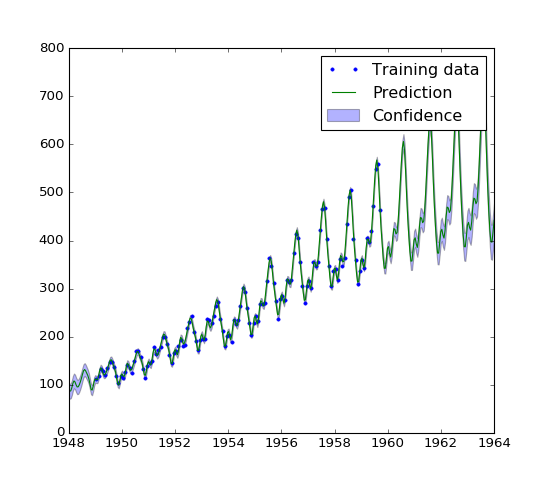

In [34]:
kernel_trend = GPy.kern.Poly(1, order=1) + GPy.kern.RBF(1) # trend
kernel_periodicity = GPy.kern.StdPeriodic(1) * GPy.kern.Linear(1) * GPy.kern.RBF(1) # periodicity
kernel_noise = GPy.kern.White(1) * GPy.kern.Linear(1) # noise

kernel = kernel_trend + kernel_periodicity + kernel_noise

plot_model(points, values, kernel)

### Thanks to Yermek Kapushev for making tutorials.

### For notebook see https://github.com/likzet/Tutorial-on-Machine-Learning-for-Industrial-Predictive-Analytics